# Option 1:

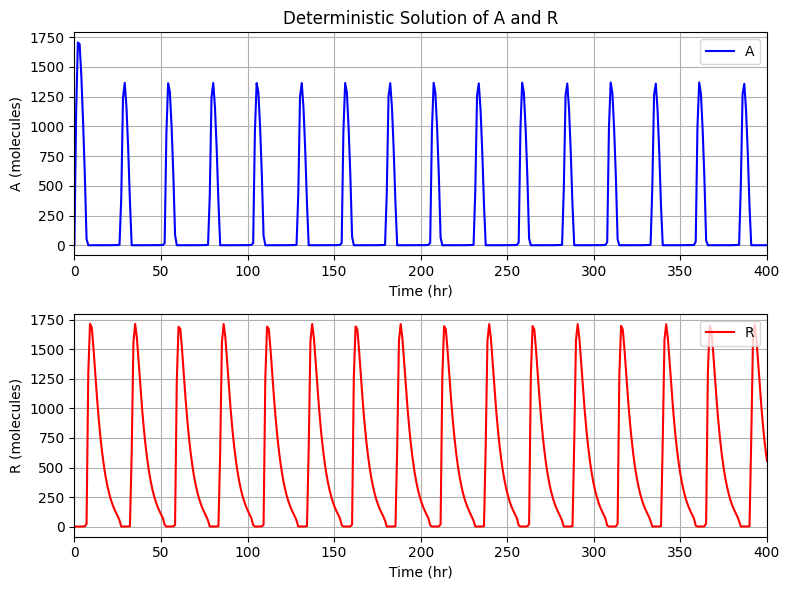

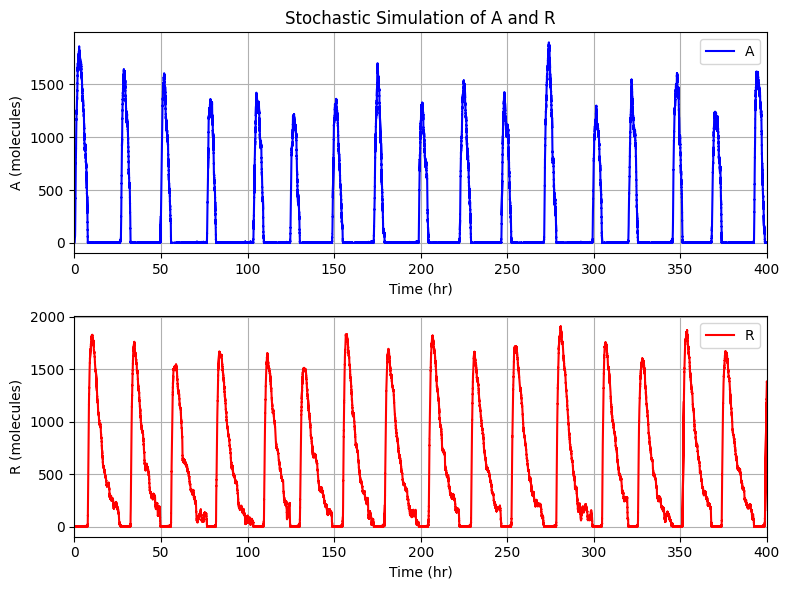

In [ ]:
# Import necessary libraries
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

# Function to generate N random numbers from exponential distribution
def random_exponential(lam, N):
    U = np.random.rand(N)  # Generate uniform random numbers
    X = -1 / lam * np.log(1 - U)  # Convert to exponential distribution
    return X

# Function to generate N random numbers from discrete distribution
def random_discrete(x, p, N):
    cdf = np.cumsum(p)  # Compute cumulative distribution function
    U = np.random.rand(N)  # Generate uniform random numbers
    idx = np.searchsorted(cdf, U)  # Find indices where random numbers fall
    return x[idx]

# Function to calculate propensity of each reaction in the model
def propensity_func(state, num_reactions):
    w = np.zeros(num_reactions)
    DA, DR, DA_prime, DR_prime, MA, A, MR, R, C = state
    # Calculate reaction propensities
    w[0] = gammaC * A * R
    w[1] = deltaA * A
    w[2] = deltaA * C
    w[3] = deltaR * R
    w[4] = gammaA * DA * A
    w[5] = gammaR * DR * A
    w[6] = thetaA * DA_prime
    w[7] = alphaA * DA
    w[8] = alphaA_prime * DA_prime
    w[9] = deltaMA * MA
    w[10] = betaA * MA
    w[11] = thetaR * DR_prime
    w[12] = alphaR * DR
    w[13] = alphaR_prime * DR_prime
    w[14] = deltaMR * MR
    w[15] = betaR * MR
    return w

# ODE function defining the model's dynamics for deterministic solution
def ode_function(t, y):
    DA, DR, DA_prime, DR_prime, MA, A, MR, R, C = y
    yprime = np.zeros(9)
    yprime[0] = thetaA * DA_prime - gammaA * DA * A
    yprime[1] = thetaR * DR_prime - gammaR * DR * A
    yprime[2] = gammaA * DA * A - thetaA * DA_prime
    yprime[3] = gammaR * DR * A - thetaR * DR_prime
    yprime[4] = alphaA_prime * DA_prime + alphaA * DA - deltaMA * MA
    yprime[5] = betaA * MA + thetaA * DA_prime + thetaR * DR_prime - A * (gammaA * DA + gammaR * DR + gammaC * R + deltaA)
    yprime[6] = alphaR_prime * DR_prime + alphaR * DR - deltaMR * MR
    yprime[7] = betaR * MR - gammaC * A * R + deltaA * C - deltaR * R
    yprime[8] = gammaC * A * R - deltaA * C
    return yprime

# Stochastic Simulation Algorithm (SSA)
def ssa(initial, state_change_matrix, final_time):
    m, n = state_change_matrix.shape
    state = initial
    states = [state.copy()]
    t = 0
    times = [t]

    while t < final_time:
        w = propensity_func(state, m)
        a = np.sum(w)
        tau = random_exponential(a, 1)
        t += tau.item()

        if t > final_time:
            break

        which_reaction = random_discrete(np.arange(m), w / a, 1)
        state = state + state_change_matrix[which_reaction.item(), :]
        times.append(t)
        states.append(state.copy())
    # Implement the SSA logic
    return np.array(times), np.array(states).T

# Model parameters and initial conditions
alphaA, alphaA_prime, alphaR, alphaR_prime = 50, 500, 0.01, 50
betaA, betaR = 50, 5
deltaMA, deltaMR, deltaA, deltaR = 10, 0.5, 1, 0.2
# deltaMA, deltaMR, deltaA, deltaR = 10, 0.5, 1, 0.05
gammaA, gammaR, gammaC = 1, 1, 2
thetaA, thetaR = 50, 100
initial = [1, 1, 0, 0, 0, 0, 0, 0, 0]
final_time = 400

state_change_matrix = np.array([
    [0, 0, 0, 0, 0, -1, 0, -1, 1],
    [0, 0, 0, 0, 0, -1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, -1],
    [0, 0, 0, 0, 0, 0, 0, -1, 0],
    [-1, 0, 1, 0, 0, -1, 0, 0, 0],
    [0, -1, 0, 1, 0, -1, 0, 0, 0],
    [1, 0, -1, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, -1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 1, 0, -1 ,0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, -1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0]
])

# Solve ODEs for deterministic solution
teval = np.linspace(0, final_time, 400)
sol = solve_ivp(ode_function, [0, final_time], initial, t_eval=teval)

# Plotting deterministic solution
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
axs[0].plot(sol.t, sol.y[5], 'b-', label='A')
axs[0].set_ylabel('A (molecules)')
axs[0].set_xlabel('Time (hr)')  # X-axis label for A
axs[0].set_xlim([0, 400])  # Setting x-axis range for A
axs[0].set_title('Deterministic Solution of A and R')
axs[0].legend(loc='upper right')
axs[0].grid(True)

axs[1].plot(sol.t, sol.y[7], 'r-', label='R')
axs[1].set_ylabel('R (molecules)')
axs[1].set_xlabel('Time (hr)')  # X-axis label for R
axs[1].set_xlim([0, 400])  # Setting x-axis range for R
axs[1].legend(loc='upper right')
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Perform SSA simulation
times, states = ssa(initial, state_change_matrix, final_time)

# Plotting SSA solution
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
axs[0].plot(times, states[5, :], 'b-', label='A')
axs[0].set_ylabel('A (molecules)')
axs[0].set_xlabel('Time (hr)')  # X-axis label for A
axs[0].set_xlim([0, 400])  # Setting x-axis range for A
axs[0].set_title('Stochastic Simulation of A and R')
axs[0].legend(loc='upper right')
axs[0].grid(True)

axs[1].plot(times, states[7, :], 'r-', label='R')
axs[1].set_ylabel('R (molecules)')
axs[1].set_xlabel('Time (hr)')  # X-axis label for R
axs[1].set_xlim([0, 400])  # Setting x-axis range for R
axs[1].legend(loc='upper right')
axs[1].grid(True)

plt.tight_layout()
plt.show()